# CobraPy example notebook

Let's start with a small example where we will use cobrapy to analyze the Recon 2 model a bit.

We begin by importing the cobrapy package and checking the version.

In [1]:
import cobra
cobra.version.get_version()

'0.5.0b2'

Okay, in order to analyze Recon 2 we first have to actually download Recon 2. The notebook allows us to use normal bash command line commands by prefixing them with "!".

In [2]:
!wget http://www.ebi.ac.uk/biomodels-main/download?mid=MODEL1603150001 -O recon2.2.xml

--2016-09-30 18:10:50--  http://www.ebi.ac.uk/biomodels-main/download?mid=MODEL1603150001
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/sbml+xml]
Saving to: ‘recon2.2.xml’

recon2.2.xml            [                  <=> ]  22.72M  1.52MB/s   in 12s    

2016-09-30 18:11:02 (1.86 MB/s) - ‘recon2.2.xml’ saved [23827124]



Reading the model into cobrapy is quite simple. The `cobra` module contains a submodule `io` that can read models from several formats such as SBML, JSON, COBRA Matlab, etc. 

In [3]:
recon2 = cobra.io.read_sbml_model("recon2.2.xml")

cobra/io/sbml.py:205 UserWarning: M_h_x appears as a reactant and product FAOXC220200x


We get a warning that there is one reaction that declares the same metabolite as product and substrate which is bad practice but not really an error. 

`recon2` is now a CobraPy model.

In [4]:
recon2

<Model MODEL1603150001 at 0x7fbbd8263978>

That means it has several associated attributes, the most important ones being `reactions` and `metabolites`.

In [5]:
print("Reactions:", len(recon2.reactions))
print("Metabolites:", len(recon2.metabolites))

Reactions: 7785
Metabolites: 5324


Each of those have associated infos. To illustrate that we will select one of the reactions, the biomass reaction of Recon 2.

In [6]:
bm = recon2.reactions.get_by_id("biomass_reaction")
print(bm.build_reaction_string())
print(bm.notes)

0.014 biomass_DNA_c + 0.058 biomass_RNA_c + 0.071 biomass_carbohydrate_c + 0.097 biomass_lipid_c + 0.054 biomass_other_c + 0.706 biomass_protein_c --> 
{'GENE ASSOCIATION': ['']}


To get the fluxes from a normal FBA we need to solve

$$\begin{align}
&\max v_{bm}\\
s.t. \quad& v^i_{min} \leq v^i \leq v^i_{max}\\
&\mathbf{Sv} = \mathbf{0}
\end{align}$$

which can be achieved with the method `optimize` of the model.

In [7]:
recon2.optimize()

<Solution 555.79 at 0x7fbbd788ebe0>

After running `optimize` each of the reactions now carries an attribute `x` containing the flux for that reaction, for instance:

In [8]:
print(bm.x)

555.7858784751152


We can use the (new) `summary` function to get an overview.

In [9]:
recon2.summary()

IN FLUXES                 OUT FLUXES                OBJECTIVES
------------------------  ------------------------  --------------------
34hpp_e            1e+03  12HPET_e           1e+03  biomass_reac...  556
3mob_e             1e+03  23cump_e           1e+03
3mop_e             1e+03  2hb_e              1e+03
3ump_e             1e+03  3ivcrn_e           1e+03
4nph_e             1e+03  4abut_e            1e+03
5HPET_c            1e+03  5oxpro_e           1e+03
C04849_e           1e+03  CE1950_e           1e+03
CE2838_e           1e+03  CE2839_e           1e+03
CE4881_e           1e+03  CE4633_e           1e+03
CE5560_e           1e+03  CE5797_e           1e+03
CE5798_e           1e+03  HC00229_e          1e+03
HC00250_e          1e+03  HC00955_e          1e+03
HC01440_e          1e+03  HC01104_e          1e+03
HC01700_e          1e+03  HC01361_e          1e+03
HC02204_e          1e+03  HC01441_e          1e+03
ach_e              1e+03  HC01446_e          1e+03
ahdt_e             1e+03  

That is a pretty long list. Usually we are probably more interested in certain pathway or metabolite. Let's try to find some infos about ATP. IDs of SBML model are often pretty convoluted strings so let us first find all metabolites that contain "atp" in their id.

In [10]:
ATPs = [m for m in recon2.metabolites if "atp" in m.id]
print(ATPs)

[<Metabolite atp_c at 0x7fbbd7822780>, <Metabolite atp_e at 0x7fbbd7822860>, <Metabolite atp_g at 0x7fbbd7822940>, <Metabolite atp_l at 0x7fbbd7822a90>, <Metabolite atp_m at 0x7fbbd7822ba8>, <Metabolite atp_n at 0x7fbbd7822cc0>, <Metabolite atp_r at 0x7fbbd7822dd8>, <Metabolite atp_x at 0x7fbbd7822ef0>, <Metabolite datp_c at 0x7fbbd77f70b8>, <Metabolite datp_m at 0x7fbbd77f7160>, <Metabolite datp_n at 0x7fbbd77f7208>]


Okay `atp_c` seems interesting so let's see a summary for it.

In [11]:
recon2.metabolites.atp_c.summary()    # this is the same as recon2.metbaolites.get_by_id("atp_c").summary()

PRODUCING REACTIONS -- ATP(4-) (atp_c)
--------------------------------------
%          FLUX  RXN ID      REACTION
---  ----------  ----------  --------------------------------------------------
5%     1e+03     ADK1        amp_c + atp_c <=> 2.0 adp_c
5%     1e+03     ATPtm       adp_c + atp_m --> adp_m + atp_c
5%     1e+03     CKc         atp_c + creat_c <=> adp_c + h_c + pcreat_c
5%     1e+03     DAGK_hs     atp_c + dag_hs_c <=> adp_c + h_c + pa_hs_c
5%     1e+03     FACOAL1821  atp_c + coa_c + lnlc_c <=> amp_c + lnlccoa_c + ...
5%     1e+03     NDPK1       atp_c + gdp_c <=> adp_c + gtp_c
5%     1e+03     NDPK2       atp_c + udp_c <=> adp_c + utp_c
5%     1e+03     NDPK3       atp_c + cdp_c <=> adp_c + ctp_c
5%     1e+03     NDPK4       atp_c + dtdp_c <=> adp_c + dttp_c
5%     1e+03     NDPK5       atp_c + dgdp_c <=> adp_c + dgtp_c
5%     1e+03     NDPK6       atp_c + dudp_c <=> adp_c + dutp_c
5%     1e+03     PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
5%     1e+03     RE2638C   

Much more interesting. So 60% of ATP is consumed for biomass...

However, FBA solutions are not unique :( So let us run a parsimonous FBA now to get the most economic solution. Which means the model hast to be converted to irreversible form in order to solve:

$$\begin{align}
&\min \sum_i v^i\\
s.t. \quad& 0 \leq v^i \leq v^i_{max}\\
&\mathbf{Sv} = \mathbf{0}
\end{align}$$

In [12]:
from cobra.flux_analysis import optimize_minimal_flux as pFBA
?pFBA

In [13]:
recon2.solution = pFBA(recon2)
recon2.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP(4-) (atp_c)
--------------------------------------
%          FLUX  RXN ID      REACTION
---  ----------  ----------  --------------------------------------------------
8%     1e+03     ADK1        amp_c + atp_c <=> 2.0 adp_c
8%     1e+03     ATPtm       adp_c + atp_m --> adp_m + atp_c
8%     1e+03     CKc         atp_c + creat_c <=> adp_c + h_c + pcreat_c
8%     1e+03     NDPK1       atp_c + gdp_c <=> adp_c + gtp_c
8%     1e+03     NDPK6       atp_c + dudp_c <=> adp_c + dutp_c
8%     1e+03     PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
8%     1e+03     PYK         adp_c + h_c + pep_c --> atp_c + pyr_c
8%     1e+03     UMPK        atp_c + ump_c <=> adp_c + udp_c
7%   886         DAGK_hs     atp_c + dag_hs_c <=> adp_c + h_c + pa_hs_c
6%   735         FACOAL1821  atp_c + coa_c + lnlc_c <=> amp_c + lnlccoa_c + ...
5%   663         RE2637C     HC02191_c + atp_c + taur_c <=> HC02192_c + amp_...
4%   552         NDPK5       atp_c + dgdp_c <=> adp_c + dgtp_c
3%  

So now 92% of ATP goes into biomass but that requires the consumption of Galactose.

Alternatively we can also use flux variability analysis to get the same info.

In [14]:
recon2.metabolites.atp_c.summary(fva=True)

PRODUCING REACTIONS -- ATP(4-) (atp_c)
--------------------------------------
%          FLUX  RANGE                 RXN ID      REACTION
---  ----------  --------------------  ----------  ----------------------------------------
8%     1e+03     [1e+03, 1e+03]        PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
8%     1e+03     [268, 1e+03]          ADK1        amp_c + atp_c <=> 2.0 adp_c
8%     1e+03     [0, 1e+03]            ATPtm       adp_c + atp_m --> adp_m + atp_c
8%     1e+03     [0, 1e+03]            CKc         atp_c + creat_c <=> adp_c + h_c + pcr...
8%     1e+03     [0, 1e+03]            PYK         adp_c + h_c + pep_c --> atp_c + pyr_c
8%     1e+03     [1e+03, -1e+03]       NDPK1       atp_c + gdp_c <=> adp_c + gtp_c
8%     1e+03     [1e+03, -1e+03]       NDPK6       atp_c + dudp_c <=> adp_c + dutp_c
8%     1e+03     [1e+03, -1e+03]       UMPK        atp_c + ump_c <=> adp_c + udp_c
7%   886         [-823, 1e+03]         DAGK_hs     atp_c + dag_hs_c <=> adp_c + h_c + pa...

So there is quite some variation. Finally, let's create a plot of the fluxes in the individual pathways.

In [15]:
import pandas as pd
from numpy import abs, mean
fluxes = pd.DataFrame({"flux": [r.x for r in recon2.reactions], 
                       "pathway": [r.subsystem for r in recon2.reactions]})
print(fluxes.head())

   flux                  pathway
0   0.0  beta-Alanine metabolism
1   0.0     Vitamin D metabolism
2   0.0     Vitamin D metabolism
3   0.0     Vitamin D metabolism
4   0.0     Vitamin D metabolism


And now we use seaborn to plot the result.

/opt/conda/lib/python3.4/site-packages/IPython/html.py:14 ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


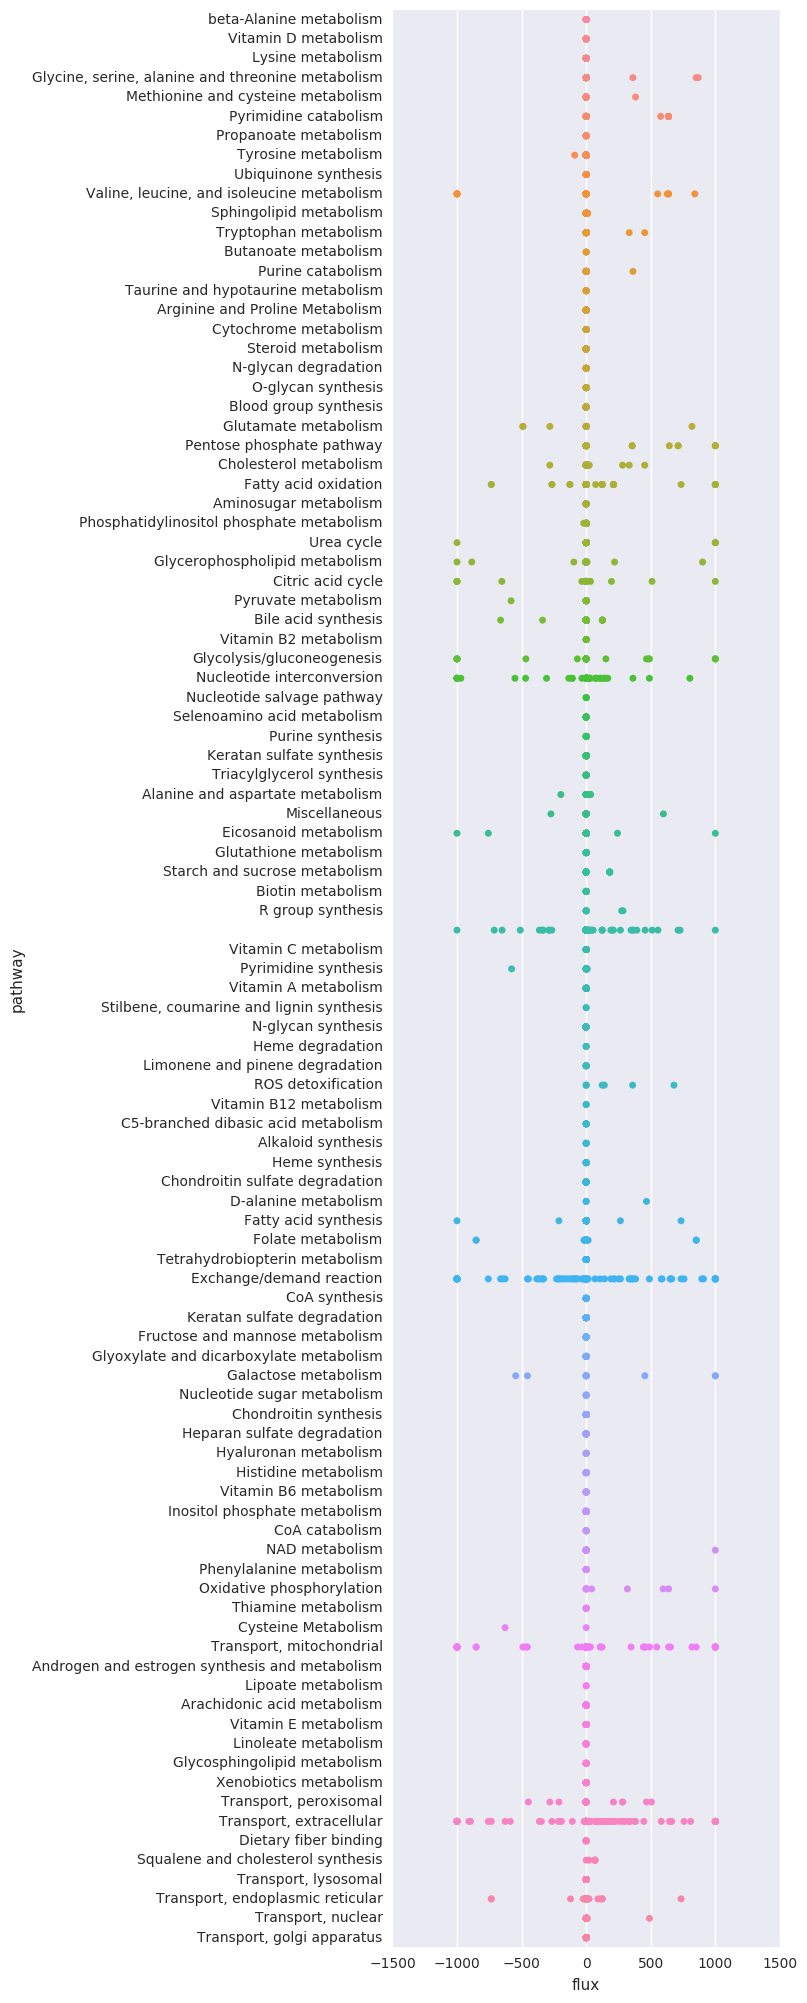

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(5,25))
ax = fig.add_subplot(111)

sns.stripplot(x="flux", y="pathway", data=fluxes, ax=ax)